In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [2]:
from utils import *
from data import *
from models import *
from train import *

In [3]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Import

In [5]:
data_1lead = import_afc_data()

labelmap = {x:i for i,x in enumerate(list(set([x[1] for x in data_1lead])))}

dataset_1lead = WindowDataset(data_1lead, labelmap, device=device)

100%|██████████| 8528/8528 [00:00<00:00, 22046.47it/s]
8528it [00:01, 7879.43it/s]


In [6]:
data_12lead = import_balanced_12lead_data()

dataset_12lead = WindowDataset(data_12lead, labelmap, device=device, trim_samples=1000)

3318it [00:03, 1089.03it/s]


In [7]:
pd.Series([x[1] for x in data_1lead]).value_counts()

N    5076
O    2415
A     758
~     279
Name: count, dtype: int64

In [8]:
pd.Series([x[1] for x in data_12lead]).value_counts()

A    1106
N    1106
O    1106
Name: count, dtype: int64

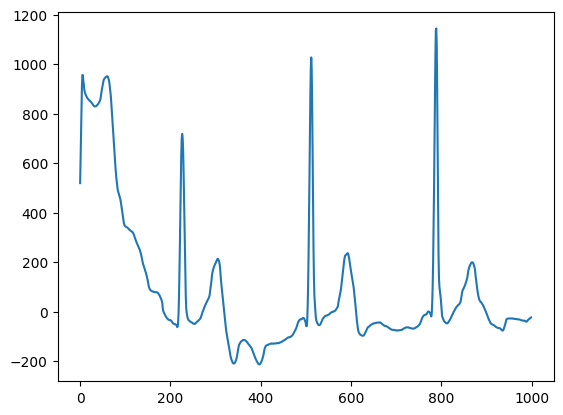

In [9]:
def plotwave(x, n=1000):
    plt.plot(x[:n])

plotwave(data_1lead[3][0])

In [10]:
value_counts = dataset_1lead.get_value_counts()
weights = [sum(value_counts)/x for x in value_counts]
weights[labelmap['~']] = weights[labelmap['N']]

# Training

In [11]:
## Train k-fold crossvalidated model on 1 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap

# history = train_kfold_model(dataset_1lead, trainparams, test=)

# plot_tt_graph(history, idx=0)
# display_results(history,trainparams=trainparams)

In [12]:
## Build model on entire 1lead dataset and save to buffer

buffer = io.BytesIO()

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs = 200

model, history = train_entire_model(dataset_1lead, trainparams)

torch.save(model.state_dict(), buffer)

Epoch:10/200 AVG Training Loss:0.02458 AVG Test Loss:0.02339 AVG Training Acc 54.43 % AVG Test Acc 58.15 %
Epoch:20/200 AVG Training Loss:0.02290 AVG Test Loss:0.02201 AVG Training Acc 59.40 % AVG Test Acc 62.72 %
Epoch:30/200 AVG Training Loss:0.02269 AVG Test Loss:0.02092 AVG Training Acc 61.66 % AVG Test Acc 62.59 %
Epoch:40/200 AVG Training Loss:0.02190 AVG Test Loss:0.02115 AVG Training Acc 62.42 % AVG Test Acc 66.74 %
Epoch:50/200 AVG Training Loss:0.02112 AVG Test Loss:0.02000 AVG Training Acc 63.66 % AVG Test Acc 66.89 %
Epoch:60/200 AVG Training Loss:0.02073 AVG Test Loss:0.01960 AVG Training Acc 64.82 % AVG Test Acc 69.65 %
Epoch:70/200 AVG Training Loss:0.01998 AVG Test Loss:0.01897 AVG Training Acc 64.82 % AVG Test Acc 69.13 %
Epoch:80/200 AVG Training Loss:0.01973 AVG Test Loss:0.01845 AVG Training Acc 65.31 % AVG Test Acc 67.69 %
Epoch:90/200 AVG Training Loss:0.01961 AVG Test Loss:0.01842 AVG Training Acc 64.88 % AVG Test Acc 69.77 %
Epoch:100/200 AVG Training Loss:0.019

In [13]:
# model = TransferCrossingLSTMModel(buffer).to(device)

# test_forwards(model,dataset_12lead,labelmap,device,batch_size=128,max_norm=1)

In [14]:
len(dataset_12lead)/20

165.9

Fold 1
Epoch:10/100 AVG Training Loss:0.01224 AVG Test Loss:0.00545 AVG Training Acc 68.28 % AVG Test Acc 68.40 %
Epoch:20/100 AVG Training Loss:0.01128 AVG Test Loss:0.00504 AVG Training Acc 76.44 % AVG Test Acc 71.11 %
Epoch:30/100 AVG Training Loss:0.01125 AVG Test Loss:0.00488 AVG Training Acc 78.55 % AVG Test Acc 72.31 %
Epoch:40/100 AVG Training Loss:0.01108 AVG Test Loss:0.00482 AVG Training Acc 80.66 % AVG Test Acc 72.75 %
Epoch:50/100 AVG Training Loss:0.01102 AVG Test Loss:0.00470 AVG Training Acc 84.89 % AVG Test Acc 74.72 %
Epoch:60/100 AVG Training Loss:0.01104 AVG Test Loss:0.00476 AVG Training Acc 84.59 % AVG Test Acc 74.02 %
Epoch:70/100 AVG Training Loss:0.01070 AVG Test Loss:0.00482 AVG Training Acc 90.03 % AVG Test Acc 74.72 %
Early stopping triggered after epoch 72
Fold 2
Epoch:10/100 AVG Training Loss:0.01210 AVG Test Loss:0.00558 AVG Training Acc 70.69 % AVG Test Acc 67.56 %
Epoch:20/100 AVG Training Loss:0.01079 AVG Test Loss:0.00499 AVG Training Acc 80.36 % AVG 

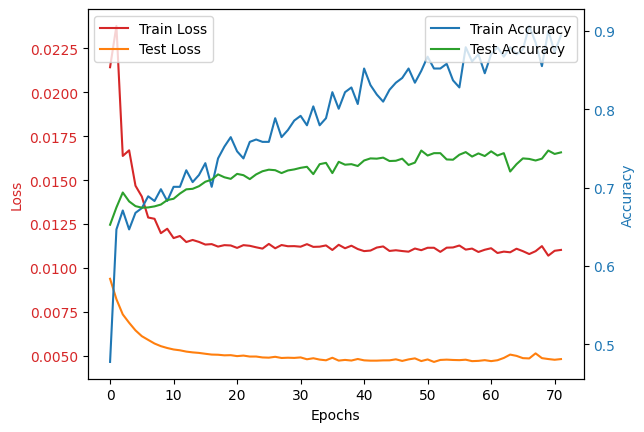

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.011184295828704411, average accuracy 88.63884541185891
Test: Average loss 0.004950286854944788, average accuracy 73.90995385002796


In [15]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data
## Transfer is done by adding a fc layer as well as allowing intermediate 

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferCrossingLSTMModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1


Epoch:10/100 AVG Training Loss:0.00654 AVG Test Loss:0.00496 AVG Training Acc 70.39 % AVG Test Acc 72.08 %
Epoch:20/100 AVG Training Loss:0.00573 AVG Test Loss:0.00470 AVG Training Acc 77.04 % AVG Test Acc 73.52 %
Epoch:30/100 AVG Training Loss:0.00535 AVG Test Loss:0.00464 AVG Training Acc 79.46 % AVG Test Acc 73.69 %
Epoch:40/100 AVG Training Loss:0.00502 AVG Test Loss:0.00468 AVG Training Acc 80.97 % AVG Test Acc 74.59 %
Epoch:50/100 AVG Training Loss:0.00470 AVG Test Loss:0.00465 AVG Training Acc 87.61 % AVG Test Acc 75.33 %
Epoch:60/100 AVG Training Loss:0.00460 AVG Test Loss:0.00483 AVG Training Acc 85.50 % AVG Test Acc 74.72 %
Early stopping triggered after epoch 62
Fold 2
Epoch:10/100 AVG Training Loss:0.00608 AVG Test Loss:0.00496 AVG Training Acc 76.44 % AVG Test Acc 70.71 %
Epoch:20/100 AVG Training Loss:0.00521 AVG Test Loss:0.00489 AVG Training Acc 80.97 % AVG Test Acc 70.91 %
Epoch:30/100 AVG Training Loss:0.00471 AVG Test Loss:0.00502 AVG Training Acc 83.69 % AVG Test Ac

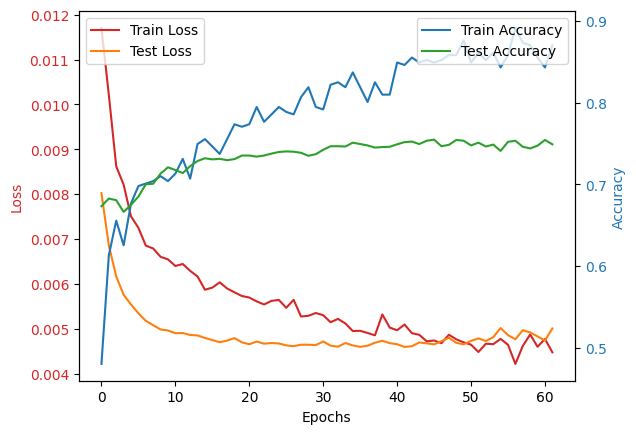

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.004650623594300442, average accuracy 86.46816874749754
Test: Average loss 0.004996416161588502, average accuracy 73.88655484325804


In [16]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferFCModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/200 AVG Training Loss:0.01062 AVG Test Loss:0.00909 AVG Training Acc 37.76 % AVG Test Acc 35.92 %
Epoch:20/200 AVG Training Loss:0.01026 AVG Test Loss:0.00886 AVG Training Acc 38.37 % AVG Test Acc 44.89 %
Epoch:30/200 AVG Training Loss:0.00972 AVG Test Loss:0.00826 AVG Training Acc 48.64 % AVG Test Acc 52.09 %
Epoch:40/200 AVG Training Loss:0.00847 AVG Test Loss:0.00765 AVG Training Acc 60.42 % AVG Test Acc 54.87 %
Epoch:50/200 AVG Training Loss:0.00701 AVG Test Loss:0.00732 AVG Training Acc 71.00 % AVG Test Acc 58.65 %
Epoch:60/200 AVG Training Loss:0.00609 AVG Test Loss:0.00737 AVG Training Acc 73.72 % AVG Test Acc 58.75 %
Epoch:70/200 AVG Training Loss:0.00522 AVG Test Loss:0.00747 AVG Training Acc 80.36 % AVG Test Acc 60.76 %
Epoch:80/200 AVG Training Loss:0.00435 AVG Test Loss:0.00780 AVG Training Acc 81.27 % AVG Test Acc 61.73 %
Early stopping triggered after epoch 83
Fold 2
Epoch:10/200 AVG Training Loss:0.01058 AVG Test Loss:0.00897 AVG Training Acc 35.95 % AVG 

Epoch:40/200 AVG Training Loss:0.00826 AVG Test Loss:0.00765 AVG Training Acc 63.44 % AVG Test Acc 55.51 %
Epoch:50/200 AVG Training Loss:0.00728 AVG Test Loss:0.00739 AVG Training Acc 68.88 % AVG Test Acc 58.19 %
Epoch:60/200 AVG Training Loss:0.00640 AVG Test Loss:0.00741 AVG Training Acc 73.72 % AVG Test Acc 59.52 %
Epoch:70/200 AVG Training Loss:0.00517 AVG Test Loss:0.00758 AVG Training Acc 81.57 % AVG Test Acc 59.22 %
Epoch:80/200 AVG Training Loss:0.00531 AVG Test Loss:0.00739 AVG Training Acc 77.34 % AVG Test Acc 60.29 %
Epoch:90/200 AVG Training Loss:0.00435 AVG Test Loss:0.00793 AVG Training Acc 84.59 % AVG Test Acc 60.46 %
Early stopping triggered after epoch 92
Fold 3
Epoch:10/200 AVG Training Loss:0.01055 AVG Test Loss:0.00905 AVG Training Acc 33.13 % AVG Test Acc 43.47 %
Epoch:20/200 AVG Training Loss:0.00995 AVG Test Loss:0.00838 AVG Training Acc 44.28 % AVG Test Acc 51.47 %
Epoch:30/200 AVG Training Loss:0.00858 AVG Test Loss:0.00779 AVG Training Acc 54.82 % AVG Test Ac

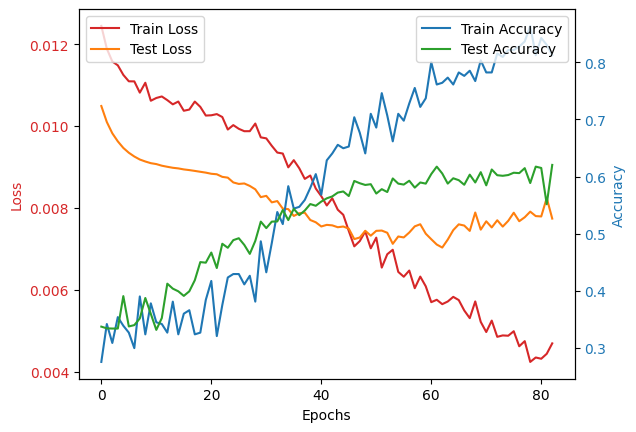

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.004089666813524117, average accuracy 86.31656535507591
Test: Average loss 0.007055805575846928, average accuracy 65.66227261647984


In [17]:
## Train k-fold crossvalidated model control - only on 12-lead data!

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs=200
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

In [18]:
# transfer_def = TransferDef()
# transfer_def.return_request = [4]

# from torch.utils.tensorboard import SummaryWriter

# model = TransferModel(buffer, transfer_def)

# # Initialize the summary writer
# writer = SummaryWriter()

# # Create dummy input that corresponds to the network's input shape
# input_tensor = torch.rand(128, 1000, 12)

# # Add the model graph to TensorBoard
# writer.add_graph(model, input_tensor)
# writer.close()


# test_forwards(model, data_12lead, labelmap, device)

In [19]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20


for base_decay in [0.00001 * 2 ** i for i in range(10)]:
    trainparams.base_decay = base_decay

    history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, buffer=buffer, test=False, verbose=False)

    # plot_tt_graph(history, idx=0)

    print(f'\n\n\n##### decay rate {base_decay}')
    display_results(history, trainparams=trainparams)




##### decay rate 1e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.0034249171661563903, average accuracy 91.65180358897828
Test: Average loss 0.0054547749947071195, average accuracy 73.49134483408905



##### decay rate 2e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.004031099271994286, average accuracy 90.41768281585556
Test: Average loss 0.005807983370761942, average accuracy 72.47328846972738



##### decay rate 4e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.0044489682841046254, average accuracy 90.62825319404506
Test: Average loss 0.005585741364324577, average accuracy 72.9790265519865



##### decay rate 8e-05
Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.004958498914534986, average accuracy 89.81336221016998
Test: Average loss 0.005770514095068302, average accuracy 72.89526662871101



##### decay rate 0.00016
Overall re

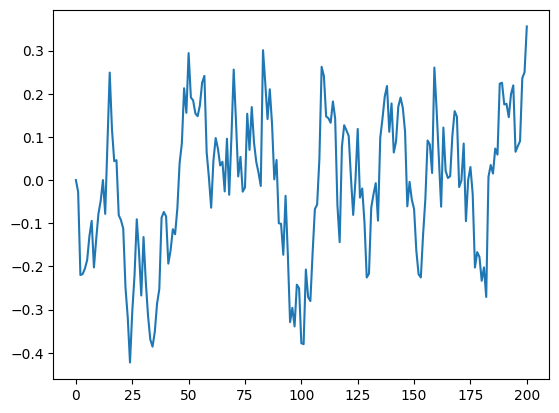

In [ ]:
RandomAugment(device)

In [ ]:
control_dataset = WindowDataset(data_1lead, labelmap, device=device, trim_samples=1000)

8528it [00:01, 7248.86it/s]


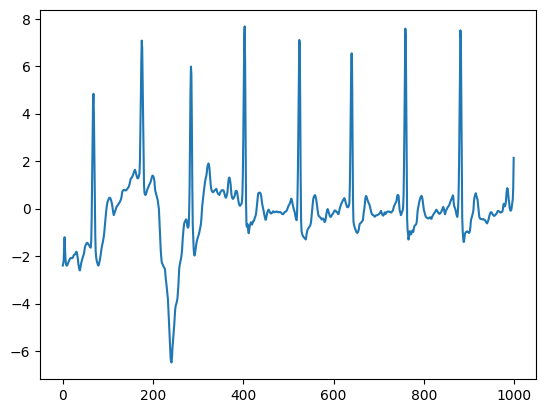

In [ ]:
waveform, label, rpeaks = control_dataset.__getitem__(0, return_rpeaks=True)
plt.plot(waveform.cpu())

In [ ]:
augment_dataset = AugmentDataset(data_1lead, labelmap, device=device, trim_samples=1000)

8528it [00:01, 7163.48it/s]


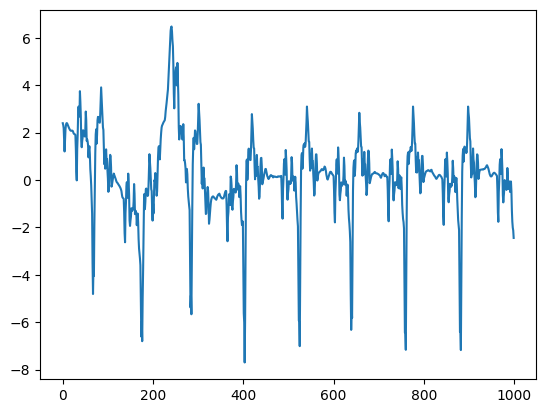

In [ ]:
waveform, label = augment_dataset.__getitem__(0)
plt.plot(waveform[:,4].cpu())

In [ ]:
augment_dataset.__getitem__(0)[0].shape

torch.Size([1000, 12])

8528it [00:01, 7242.58it/s]


Fold 1
0
1
2
3
4
5
6
7
8
9
Epoch:10/100 AVG Training Loss:0.00685 AVG Test Loss:0.00594 AVG Training Acc 70.42 % AVG Test Acc 69.97 %
10
11
12
13
14
15
16
17
18
19
Epoch:20/100 AVG Training Loss:0.00645 AVG Test Loss:0.00578 AVG Training Acc 74.18 % AVG Test Acc 70.67 %
20
21
22
23
24
25
26
27
28
29
Epoch:30/100 AVG Training Loss:0.00602 AVG Test Loss:0.00585 AVG Training Acc 77.23 % AVG Test Acc 70.44 %
30
31
32
33
34
35
36
37
38
39
Epoch:40/100 AVG Training Loss:0.00571 AVG Test Loss:0.00578 AVG Training Acc 79.46 % AVG Test Acc 70.65 %
40
41
42
43
44
Early stopping triggered after epoch 45


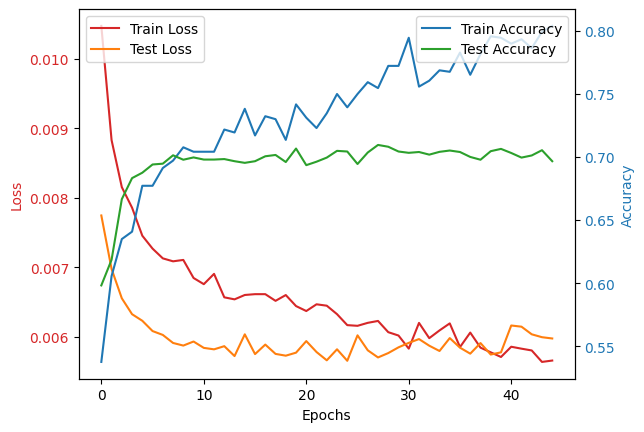

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.0056621919215565, average accuracy 80.39906103286386
Test: Average loss 0.005979426612824186, average accuracy 70.96143824908808


In [ ]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

augment_dataset = AugmentDataset(data_1lead, labelmap, device=device, trim_samples=1000)

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(augment_dataset, trainparams, Transfer1LSTMModel, buffer=buffer, test=True)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)